In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from bayes3d._mkl.table_scene_model import *

In [8]:
import jax
from jax import jit, vmap

key = jax.random.PRNGKey(0)

## Renderer and meshes

In [6]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


# Add invisible atomic table
mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-9
meshes.append(mesh)


In [7]:
#| Set up the renderer and add the scene mesh
def make_render_function(meshes, w=100, h=100, fx=30, fy=30, offx=-0.5, offy=-0.5, far=20, near=0.01):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx = fx, fy = fy,
        cx = w/2 + offx, cy = h/2 + offy,
        near = near, far = far
    )
    
    b3d.setup_renderer(intrinsics)
    for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

    def render(cam:"Camera Pose", ps:"Object Poses", inds:"Object indices"):
        """
        Returns image of shape `(h, w, 4)` where the first 3 channels encode 
        xyz-coordinates and the last channel encodes semantic information.
        """
        return b3d.RENDERER.render(inv(cam) @ ps , inds)

    return render

In [8]:
_far   = 5.0
_shape = (200,200)
_f     = 300

_intr   = dict(w=_shape[1], h=_shape[0], fx=_f, fy=_f, near=0.0001, far=_far)
render   = make_render_function(meshes, **_intr)

help(render)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)
Help on function render in module __main__:

render(cam: 'Camera Pose', ps: 'Object Poses', inds: 'Object indices')
    Returns image of shape `(h, w, 4)` where the first 3 channels encode 
    xyz-coordinates and the last channel encodes semantic information.



## Example

In [20]:
fname = f"table_scene_3"
arr = jnp.load(f"data/likelihood_test/{fname}.npy", allow_pickle=True)
ch = arr.item()["choices"]


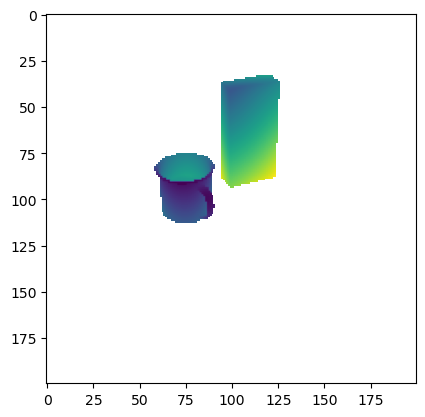

In [183]:
_, tr_ = model.importance(key, ch , args)
cam, ps, inds = tr_.retval
X = render(cam, ps, inds)

# =====================
plt.imshow(prep_im(X))

## Generic Viewpoint

In [50]:
from xsight.pose import pack_pose

def generic_viewpoint(key, cam, n, sig_x, sig_hd):
    """Generates generix camera poses by varying its xy-coordinates and angle (in the xy-plane)."""
    
    # TODO: Make a version that varies rot and pitch and potentially roll.
    
    _, keys = keysplit(key,1,2)

    # Generic position
    xs = sig_x*jax.random.normal(keys[1], (n,3))
    xs = xs.at[0,:].set(0.0)
    xs = xs.at[:,2].set(0.0)

    # Generic rotation
    hds = sig_hd*jax.random.normal(keys[0], (n,))
    hds = hds.at[0].set(0.0)
    rs = vmap(Rotation.from_euler, (None,0))("y", hds)
    rs = Rotation.as_matrix(rs)
    
    # Generic camera poses
    ps = vmap(pack_pose)(xs, rs)
    ps = cam@ps

    # Generic weights
    logps_hd = normal_logpdf(hds, loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf( xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    return ps, logps


In [51]:
def generic_contact(key, p0, n, sig_x, sig_hd):

    _, keys = keysplit(key,1,2)

    # Generic contact-pose vector
    xs  = sig_x*jax.random.normal(keys[1], (n,3))
    xs  = xs.at[:,2].set(0.0)
    xs  = xs.at[0,:].set(0.0)

    hds = sig_hd*jax.random.normal(keys[0], (n,1))
    hds = hds.at[0,:].set(0.0)
    rs = vmap(Rotation.from_euler, (None,0))("z", hds)
    rs = Rotation.as_matrix(rs)
    
    # Generic camera poses
    ps = vmap(pack_pose)(xs, rs)
    # vs  = jnp.concatenate([xs, hds], axis=1)

    # Generic weights
    logps_hd = normal_logpdf(hds[:,0], loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf (xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    # Generic object pose
    generic_ps = p0@ps

    return generic_ps, logps



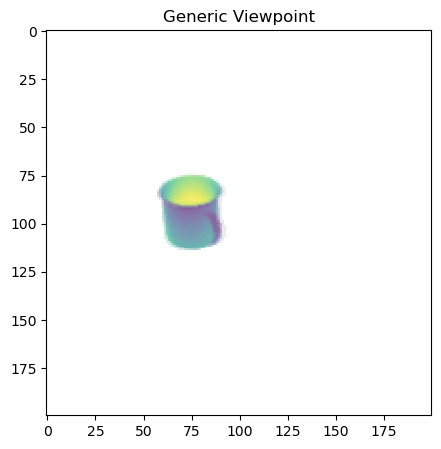

In [235]:
key = keysplit(key)
p0 = ps[1]
generic_ps, ws = generic_contact(key, p0, n=10, sig_x=0.004, sig_hd=0.01)
ws -= logsumexp(ws)


Ys = vmap(render, (None,0,None))(cam, generic_ps[:,None], inds[1][None])


# ==============================
plt.figure(figsize=(5,5))
plt.title("Generic Viewpoint")
for Y in Ys[:]:
    plt.imshow(prep_im(Y), alpha=0.1)

In [236]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

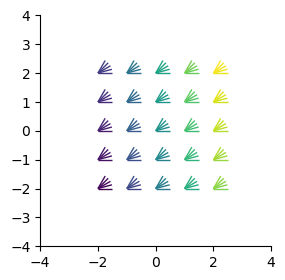

In [237]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [238]:
def _contact_from_grid(v, p0=jnp.eye(4), sig_x=1.0, sig_hd=1.0):
    x = jnp.array([*v[:2],0.0])
    hd = v[2]

    r = Rotation.from_euler("z", hd)
    r = Rotation.as_matrix(r)
    p = pack_pose(x, r)

    logp_hd = normal_logpdf(hd, loc=0.0, scale=sig_hd)
    logp_x  = normal_logpdf (x, loc=0.0, scale=sig_x).sum(-1)
    logp    = logp_hd + logp_x

    return p0@p, logp

contact_from_grid = vmap(_contact_from_grid, (0,None,None,None))

In [241]:
dx  = 0.1
dhd = jnp.pi/4
sig_hd = dhd
sig_x  = dx

ley = keysplit(key)
v0 = 0.01*jax.random.normal(key, (3,))
vs = get_linear_grid((10, 10, 10), ((-dx,dx), (-dx,dx), (-dhd,dhd)), flat=True)
vs += v0


generic_ps, logps = contact_from_grid(vs, p0, sig_x, sig_hd)

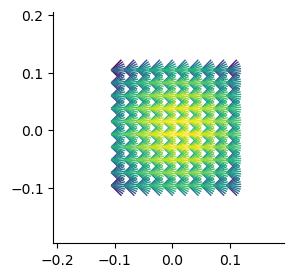

In [244]:
sc =  logps

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 0.1, ax=ax)
plot_poses(vs, sc, r=0.025, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [245]:
render_generic = jit(vmap(render, (None,0,None)))

In [246]:
Ys = render_generic(cam, generic_ps[:,None], inds[1][None])

# ==============================
plt.figure(figsize=(5,5))
plt.title("Generic Viewpoint")
for Y in Ys[:10]:
    plt.imshow(prep_im(Y), alpha=.1)

Error in callback <function _draw_all_if_interactive at 0x7f6954368f70> (for post_execute):


KeyboardInterrupt: 